# **<font color='8d5383'>Import library</font>**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Distribution, Poisson
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
N_SAMPLES = 5000  # Number of samples to generate
N_FEATURES = 1  # Number of features
EPOCHS = 200  # Number of training epochs
LEARNING_RATE = 0.01  # Learning rate
SEED = 42  # Random seed for reproducibility

torch.manual_seed(SEED)
np.random.seed(SEED)

# **<font color='8d5383'>CMP Distribution Class & Loss Function</font>**

In [ ]:

class CMPDistribution(Distribution):
    """
    A custom distribution class for Conway-Maxwell-Poisson (CMP) distribution.
    This class is used as the basis for the negative log-likelihood loss function.
    """
    def __init__(self, lambda_param, nu_param, max_y=50, validate_args=None):
        """
        Initializes the CMP distribution.

        Args:
            lambda_param (torch.Tensor): The lambda parameter (rate).
            nu_param (torch.Tensor): The nu parameter (dispersion).
            max_y (int): The maximum value to sum up to for the normalization constant.
        """
        self.lambda_param = lambda_param
        self.nu_param = nu_param
        self.max_y = max_y
        super().__init__(validate_args=validate_args)

    def log_prob(self, value):
        """
        Calculates the log probability of a given value.

        Args:
            value (torch.Tensor): The observed count value.
        """
        # Calculate log_p(Y=y) = y*log(lambda) - nu*log(y!) - log(Z)

        # y*log(lambda)
        log_lambda_term = value * torch.log(self.lambda_param)

        # -nu*log(y!)
        log_factorial_term = -self.nu_param * torch.lgamma(value + 1)

        # -log(Z)
        # Calculate the normalization constant Z(lambda, nu) using a loop for summation
        # A more efficient method would use a precomputed table or a more advanced approximation.
        Z = torch.zeros_like(self.lambda_param)
        for y in range(self.max_y):
            log_term = y * torch.log(self.lambda_param) - self.nu_param * torch.lgamma(torch.tensor(y + 1, dtype=torch.float32))
            term = torch.exp(log_term)
            Z += term
        log_Z_term = -torch.log(Z)

        return log_lambda_term + log_factorial_term + log_Z_term

    def sample(self, sample_shape=torch.Size()):
        """
        Dummy sample method (not used in this simulation but required for the Distribution class).
        """
        raise NotImplementedError("Sampling from CMP is complex and not implemented in this simplified class.")

# CMP Negative Log-Likelihood Loss Function

def cmp_nll_loss(lambda_param, nu_param, y_true):
    """
    Calculates the negative log-likelihood loss for the CMP distribution.

    Args:
        lambda_param (torch.Tensor): Predicted lambda.
        nu_param (torch.Tensor): Predicted nu.
        y_true (torch.Tensor): True observed counts.
    """
    # Create the distribution for the batch
    dist = CMPDistribution(lambda_param, nu_param)
    # Calculate the negative log probability of the true values
    return -torch.mean(dist.log_prob(y_true))

# **<font color='8d5383'>Neural Network Model</font>**

In [ ]:

class CMPNeuralNetwork(nn.Module):
    """
    A neural network model with two heads: one for lambda and one for nu.
    """
    def __init__(self, input_dim):
        """
        Initializes the neural network.

        Args:
            input_dim (int): The number of input features.
        """
        super().__init__()
        self.shared_layer = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU()
        )
        self.lambda_head = nn.Sequential(
            nn.Linear(64, 1),
            nn.Softplus() # Softplus ensures lambda > 0
        )
        self.nu_head = nn.Sequential(
            nn.Linear(64, 1),
            nn.Softplus() # Softplus ensures nu > 0
        )

    def forward(self, x):
        """
        Performs the forward pass of the network.

        Args:
            x (torch.Tensor): Input data.
        """
        shared_output = self.shared_layer(x)
        lambda_param = self.lambda_head(shared_output)
        nu_param = self.nu_head(shared_output)
        return lambda_param, nu_param




# **<font color='8d5383'>Simulation Scenarios</font>**

In [ ]:

def simulate_data(nu_value, n_samples):
    """
    Generates synthetic data for a given nu parameter.

    Args:
        nu_value (float): The dispersion parameter for data generation.
    """
    X = torch.rand(n_samples, N_FEATURES) * 10

    # Simple linear relationship for lambda
    true_lambda = 0.5 * X[:, 0] + 1.0

    # This is a simplification; we are not sampling directly from CMP
    # Instead, we will simulate different dispersion levels for a Poisson-like process.
    if nu_value == 1:
        # Poisson-like (variance approx. mean)
        y = torch.poisson(true_lambda)
    elif nu_value > 1:
        # Over-dispersion (variance > mean)
        y = torch.round(torch.poisson(true_lambda * nu_value) / nu_value)
    else:
        # Under-dispersion (variance < mean)
        y = torch.round(torch.poisson(true_lambda * nu_value) / nu_value)

    y = y.view(-1, 1)

    return X, y, true_lambda


# Training Function

def train_model(model, X, y, criterion, optimizer, epochs=EPOCHS):
    """
    Trains the model for a number of epochs.

    Args:
        model (nn.Module): The neural network model.
        X (torch.Tensor): Input features.
        y (torch.Tensor): True labels.
        criterion (function): Loss function.
        optimizer (optim.Optimizer): Optimization algorithm.
    """
    losses = []
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        lambda_pred, nu_pred = model(X)
        loss = criterion(lambda_pred, nu_pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses



# Estimator Properties Analysis Function

def analyze_estimator_properties(nu_value, sample_sizes, n_runs=10):
    """
    Analyzes the consistency and unbiasedness of the CMP estimator
    by training the model on different sample sizes.

    Args:
        nu_value (float): The dispersion parameter for data generation.
        sample_sizes (list): A list of sample sizes to test.
        n_runs (int): Number of runs for each sample size to get a distribution.

    Returns:
        tuple: A tuple containing lists of mean and variance of estimated lambda and nu.
    """
    print("\nStarting estimator properties analysis...")

    mean_lambda_estimates = []
    mean_nu_estimates = []
    var_lambda_estimates = []
    var_nu_estimates = []

    # Run the simulation for each specified sample size
    for size in sample_sizes:
        print(f"  Analyzing for sample size: {size}...")
        lambda_estimates = []
        nu_estimates = []

        # Perform multiple runs to get a distribution of estimates
        for _ in range(n_runs):
            X, y, true_lambda = simulate_data(nu_value, size)

            cmp_model = CMPNeuralNetwork(input_dim=N_FEATURES)
            cmp_optimizer = optim.Adam(cmp_model.parameters(), lr=LEARNING_RATE)
            train_model(cmp_model, X, y, cmp_nll_loss, cmp_optimizer, epochs=100) # Shorter epochs for faster simulation

            cmp_model.eval()
            with torch.no_grad():
                lambda_cmp_pred, nu_cmp_pred = cmp_model(X)

            lambda_estimates.append(lambda_cmp_pred.mean().item())
            nu_estimates.append(nu_cmp_pred.mean().item())

        # Calculate and store the mean and variance for this sample size
        mean_lambda_estimates.append(np.mean(lambda_estimates))
        mean_nu_estimates.append(np.mean(nu_estimates))
        var_lambda_estimates.append(np.var(lambda_estimates))
        var_nu_estimates.append(np.var(nu_estimates))

    return mean_lambda_estimates, mean_nu_estimates, var_lambda_estimates, var_nu_estimates

# **<font color='8d5383'>Running models and displaying plots</font>**

<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
<>:57: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
<>:57: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1991988653.py:55: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(X_sorted.numpy(), true_lambda_sorted.numpy(), label="True $\lambda$", color='black', linestyle='--')
/tmp/ipython-input-1991988653.py:56: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(X_sorted.numpy(), lambda_cmp_pred_sorted.numpy(), label="CMP Predicted $\lambda$", color='blue', linewidth=2)
/tmp/ipython-input-1991988653.py:57: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(X_sorted.numpy(), lambda_poisson_pred_sorted.numpy(), label="Poisson Predicted $\lambda$", color='red', linestyle=':', linewidth=2)


Starting simulation...

Simulating for Poisson Case (ν=1)...


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/distributions/distribution.py:62: UserWarning: <class '__main__.CMPDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
100%|██████████| 200/200 [00:00<00:00, 331.69it/s]



Simulating for Over-dispersion Case (ν>1)...


100%|██████████| 200/200 [00:00<00:00, 226.40it/s]



Simulating for Under-dispersion Case (ν<1)...


100%|██████████| 200/200 [00:00<00:00, 244.49it/s]



Starting estimator properties analysis...
  Analyzing for sample size: 500...


100%|██████████| 100/100 [00:01<00:00, 95.93it/s]


  Analyzing for sample size: 1000...


100%|██████████| 100/100 [00:01<00:00, 85.90it/s]


  Analyzing for sample size: 2000...


100%|██████████| 100/100 [00:01<00:00, 71.06it/s]


  Analyzing for sample size: 3000...


100%|██████████| 100/100 [00:01<00:00, 70.31it/s]


  Analyzing for sample size: 4000...


100%|██████████| 100/100 [00:01<00:00, 68.28it/s]


  Analyzing for sample size: 5000...


100%|██████████| 100/100 [00:01<00:00, 51.43it/s]


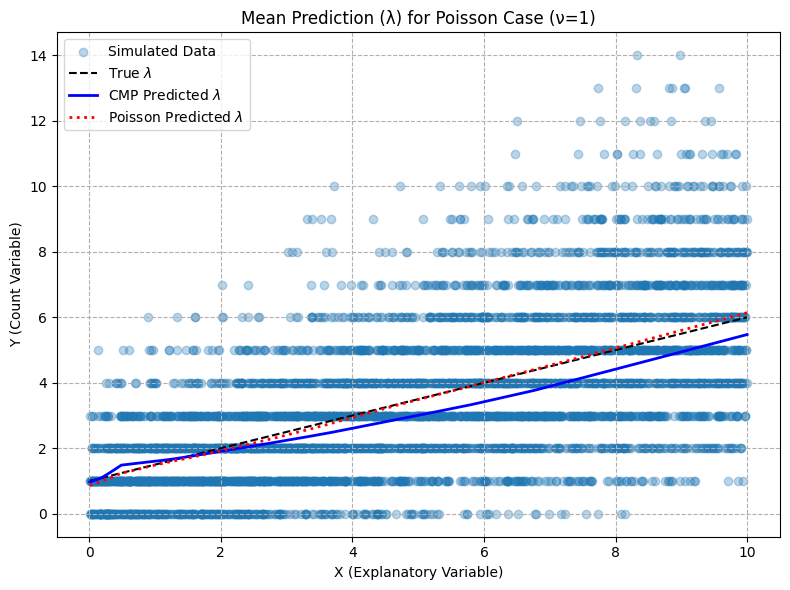

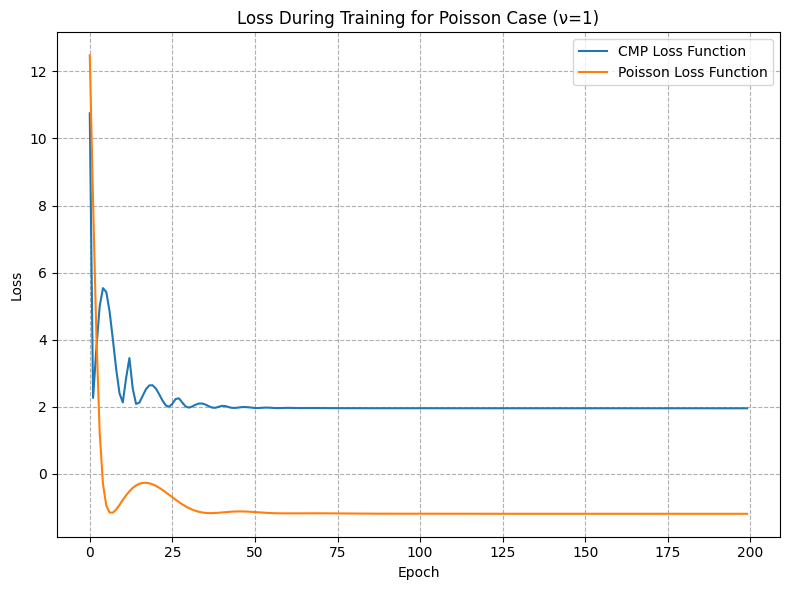

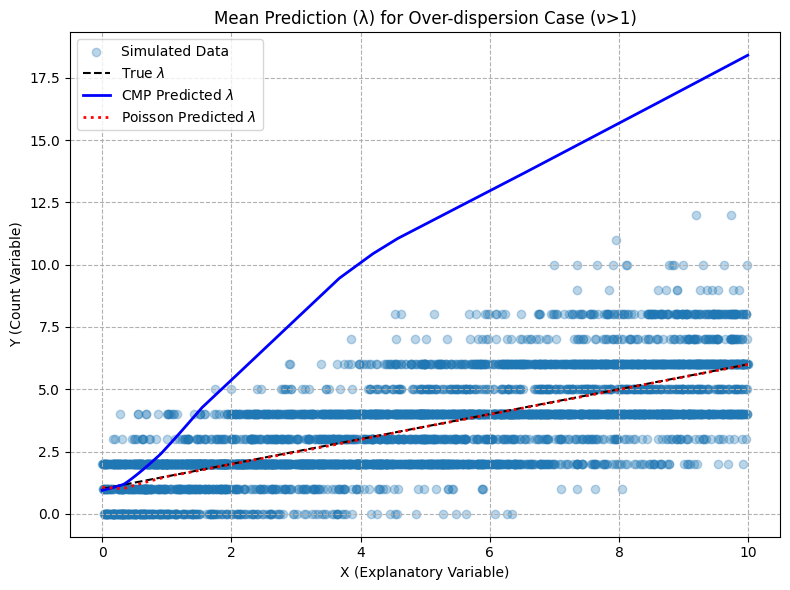

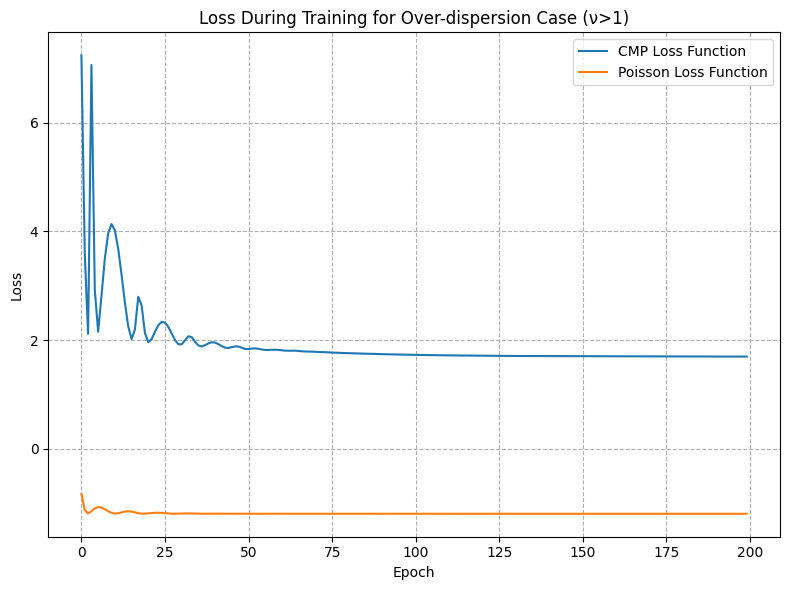

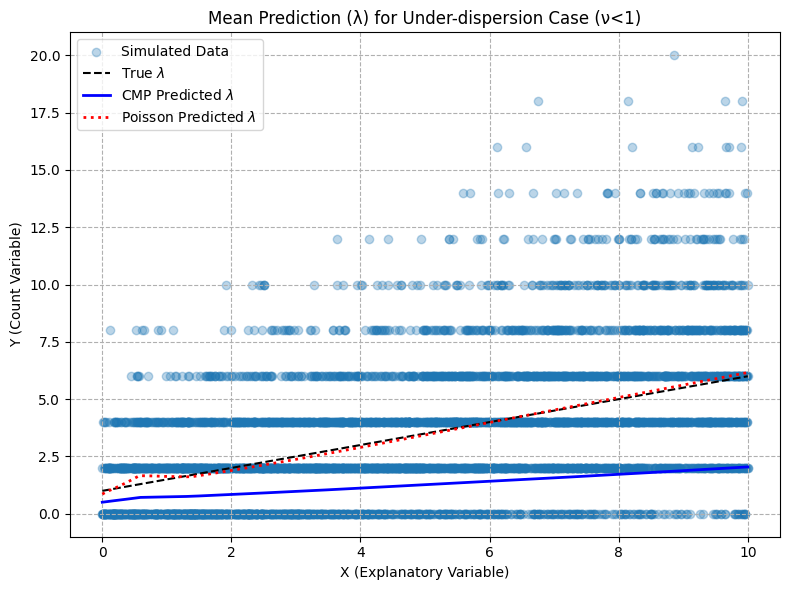

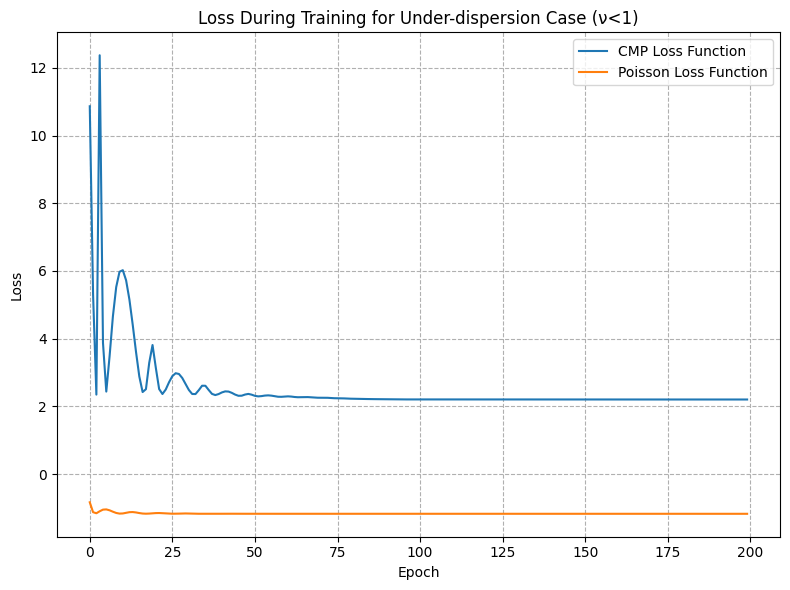

In [ ]:
print("Starting simulation...")
nu_values = [1.0, 2.0, 0.5]
nu_labels = ["Poisson Case (ν=1)", "Over-dispersion Case (ν>1)", "Under-dispersion Case (ν<1)"]

# Create separate plots for each simulation scenario
for i, nu in enumerate(nu_values):
    print(f"\nSimulating for {nu_labels[i]}...")
    X, y, true_lambda = simulate_data(nu, N_SAMPLES)

    # CMP Model Training
    cmp_model = CMPNeuralNetwork(input_dim=N_FEATURES)
    cmp_optimizer = optim.Adam(cmp_model.parameters(), lr=LEARNING_RATE)
    cmp_losses = train_model(cmp_model, X, y, cmp_nll_loss, cmp_optimizer)

    cmp_model.eval()
    with torch.no_grad():
        lambda_cmp_pred, nu_cmp_pred = cmp_model(X)

    # Poisson Model Training for comparison
    poisson_model = nn.Sequential(
        nn.Linear(N_FEATURES, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Softplus() # Softplus for non-negative output
    )
    # Poisson NLL is a simpler loss function
    poisson_loss = nn.PoissonNLLLoss(log_input=False)
    poisson_optimizer = optim.Adam(poisson_model.parameters(), lr=LEARNING_RATE)

    poisson_losses = []
    for epoch in tqdm(range(EPOCHS)):
        poisson_optimizer.zero_grad()
        lambda_poisson_pred = poisson_model(X)
        # The loss function expects log-lambda as input, so we use log(lambda_poisson_pred + 1e-8) for stability
        loss = poisson_loss(lambda_poisson_pred + 1e-8, y)
        loss.backward()
        poisson_optimizer.step()
        poisson_losses.append(loss.item())

    poisson_model.eval()
    with torch.no_grad():
        lambda_poisson_pred = poisson_model(X)

    # Sort values for plotting
    sort_idx = torch.argsort(X[:, 0])
    X_sorted = X[sort_idx]
    y_sorted = y[sort_idx]
    true_lambda_sorted = true_lambda[sort_idx]
    lambda_cmp_pred_sorted = lambda_cmp_pred[sort_idx]
    lambda_poisson_pred_sorted = lambda_poisson_pred[sort_idx]

    # Create a new plot window for Prediction vs True Lambda
    plt.figure(figsize=(8, 6))
    plt.scatter(X_sorted.numpy(), y_sorted.numpy(), alpha=0.3, label="Simulated Data")
    plt.plot(X_sorted.numpy(), true_lambda_sorted.numpy(), label="True $\lambda$", color='black', linestyle='--')
    plt.plot(X_sorted.numpy(), lambda_cmp_pred_sorted.numpy(), label="CMP Predicted $\lambda$", color='blue', linewidth=2)
    plt.plot(X_sorted.numpy(), lambda_poisson_pred_sorted.numpy(), label="Poisson Predicted $\lambda$", color='red', linestyle=':', linewidth=2)
    plt.title(f"Mean Prediction (λ) for {nu_labels[i]}")
    plt.xlabel("X (Explanatory Variable)")
    plt.ylabel("Y (Count Variable)")
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.tight_layout()

    # --- Create a new plot window for Loss over epochs ---
    plt.figure(figsize=(8, 6))
    plt.plot(cmp_losses, label="CMP Loss Function")
    plt.plot(poisson_losses, label="Poisson Loss Function")
    plt.title(f"Loss During Training for {nu_labels[i]}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.tight_layout()


# Consistency and Efficiency Analysis


# Define sample sizes and number of runs for analysis
sample_sizes = [500, 1000, 2000, 3000, 4000, 5000]
nu_value_to_test = 1.5 # We test with over-dispersion

mean_lambda, mean_nu, var_lambda, var_nu = analyze_estimator_properties(
    nu_value_to_test, sample_sizes, n_runs=10
)

# Find a representative true lambda for plotting
true_lambda_for_plot = np.mean([0.5 * x + 1.0 for x in np.random.rand(100) * 10])

# **<font color='8d5383'>Mean & Variance plots</font>**

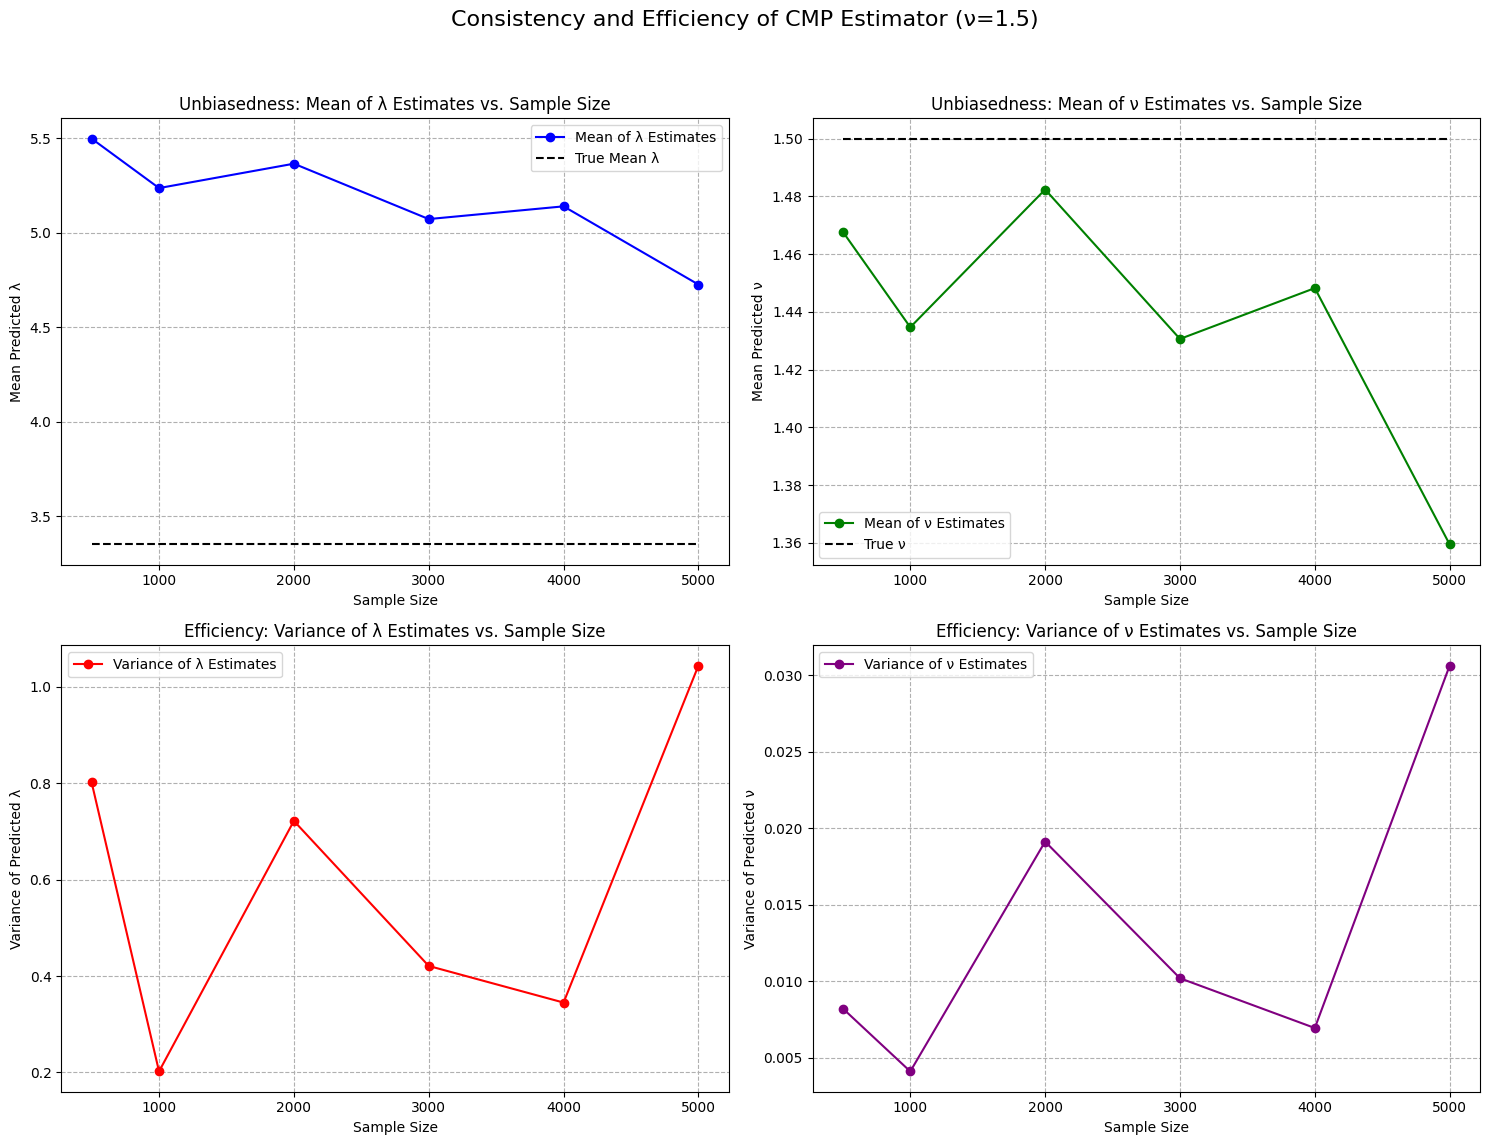

In [ ]:
# Create new figure for consistency plots
plt.figure(figsize=(15, 12))
plt.suptitle("Consistency and Efficiency of CMP Estimator (ν=1.5)", fontsize=16)

# Plot 1: Unbiasedness & Consistency (Mean of Lambda Estimator)
ax1 = plt.subplot(2, 2, 1)
ax1.plot(sample_sizes, mean_lambda, 'o-', color='blue', label="Mean of λ Estimates")
ax1.plot(sample_sizes, [true_lambda_for_plot] * len(sample_sizes), '--', color='black', label="True Mean λ")
ax1.set_title("Unbiasedness: Mean of λ Estimates vs. Sample Size")
ax1.set_xlabel("Sample Size")
ax1.set_ylabel("Mean Predicted λ")
ax1.legend()
ax1.grid(True, linestyle='--')

# Plot 2: Unbiasedness & Consistency (Mean of Nu Estimator)
ax2 = plt.subplot(2, 2, 2)
ax2.plot(sample_sizes, mean_nu, 'o-', color='green', label="Mean of ν Estimates")
ax2.plot(sample_sizes, [nu_value_to_test] * len(sample_sizes), '--', color='black', label="True ν")
ax2.set_title("Unbiasedness: Mean of ν Estimates vs. Sample Size")
ax2.set_xlabel("Sample Size")
ax2.set_ylabel("Mean Predicted ν")
ax2.legend()
ax2.grid(True, linestyle='--')

# Plot 3: Efficiency (Variance of Lambda Estimator)
ax3 = plt.subplot(2, 2, 3)
ax3.plot(sample_sizes, var_lambda, 'o-', color='red', label="Variance of λ Estimates")
ax3.set_title("Efficiency: Variance of λ Estimates vs. Sample Size")
ax3.set_xlabel("Sample Size")
ax3.set_ylabel("Variance of Predicted λ")
ax3.legend()
ax3.grid(True, linestyle='--')

# Plot 4: Efficiency (Variance of Nu Estimator)
ax4 = plt.subplot(2, 2, 4)
ax4.plot(sample_sizes, var_nu, 'o-', color='purple', label="Variance of ν Estimates")
ax4.set_title("Efficiency: Variance of ν Estimates vs. Sample Size")
ax4.set_xlabel("Sample Size")
ax4.set_ylabel("Variance of Predicted ν")
ax4.legend()
ax4.grid(True, linestyle='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
